# This notebook provides an example script for running association test

# 1. Perform regression

In [1]:
# load modules
from tqdm import tqdm

import csv
import pandas as pd
import numpy as np

import math
import random
import statsmodels.api as sm
from sklearn import preprocessing
import statsmodels.stats.multitest
import subprocess
import matplotlib.pyplot as plt

def getLineCount(filename):
    try:
        # Run wc -l command to count lines in the file
        result = subprocess.run(['wc', '-l', filename], capture_output=True, text=True, check=True)
        # Extract the line count from the output
        line_count = int(result.stdout.split()[0])
        return line_count
    except subprocess.CalledProcessError:
        # Handle errors, such as file not found
        print("Error: File not found or command failed.")
        return None

import matplotlib.pyplot as plt

import sys
import cyvcf2

In [15]:
# helper functions
def getData(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            yield row

def exonstrSLR(chrom, Pop, files_dir, minTs=10, mingt=3, minsPgt=3, search_range=100_000):
    """
    Pop: population 
    minTs: minimum samples required for regression
    mingt: minimum genotypes required for regression
    minsPgt: minimum samples required for genotypes to be included in regression
    search_range: ranges search for associated STRs
    """

    #load covariates
    cov_df=pd.read_csv(f'{files_dir}/covariates_all.csv',sep='\t',index_col='sample_id')
    exp_df=pd.read_csv(f'{files_dir}/'+Pop+'_normalized_and_filtered_hg38_chr'+str(chrom)+'.csv',sep='\t')
    gt_dir=f'{files_dir}/chr'+str(chrom)+'.GB.FORMAT'
    
    csv_gen = getData(gt_dir)
    total_gt_n=getLineCount(gt_dir)
    row_count = 0
    
    p_df = pd.DataFrame(columns =[ "str-gene","str_end","motif","gene_name", "sample_n",\
        "GT_n","p_values","slope",'error',"shuffled_p","shuffled_slope","shuffled_error"])
    
    p_df_list = []
    
    #the total length just for illustration purpose, can remove tqdm when running in large batches
    for row in tqdm(csv_gen,total=total_gt_n):
        if row_count==0:
            #extract sample name of current STR
            col_name=row[0].split('\t')
            row_count+=1
            continue

        gt_value=list(filter(lambda a: a!='',row[0].split('\t')))
        gt_df=pd.DataFrame([gt_value],columns=col_name)
        gt_df[gt_df.columns[4:]]=gt_df[gt_df.columns[4:]]. \
                applymap(lambda x: [int(x.split('/')[0]),int(x.split('/')[1])] if '/' in x else [None,None])
        gt_samples=gt_df.columns[4:][gt_df.iloc[0,4:].apply(lambda x: x !=[None,None])].to_list()
        gt_psi_samples=list(set(exp_df.columns[5:]) & set(gt_samples))
        
        #STR GENOTYPE FILTER
        gt_psi_phased=gt_df[gt_psi_samples].T.rename(columns={0:'GT'}).applymap(lambda x: sum(x))
        gt_sum=gt_psi_phased.groupby('GT').size()

        #get joint data
        gt_ab_3=gt_sum[gt_sum>=minsPgt].index.tolist()
        
        #check number of genotype and check how many samples remains
        if len(gt_ab_3)<mingt or gt_sum[gt_ab_3].sum()<minTs:
            row_count+=1
            continue

        gt_psi_filted_samples=set(gt_psi_phased[gt_psi_phased.GT.isin(gt_ab_3)].index) & set(cov_df.index)
        gt_psi_samples=list(gt_psi_filted_samples)

        gt_df=gt_df[gt_df.columns[0:4].to_list()+gt_psi_samples]
        joint_cov_df=cov_df.loc[gt_psi_samples]
        joint_exp_df=exp_df[exp_df.columns[0:5].tolist()+gt_psi_samples]
        joint_exp_df=joint_exp_df[joint_exp_df.chromosome.values == gt_df['CHROM'].values]

        paired_df=joint_exp_df[(joint_exp_df.start - search_range <= int(gt_df.POS)) \
                        & (joint_exp_df.end + search_range >= (int(gt_df.POS)))]

        if paired_df.empty:
            row_count+=1
            continue

        for index, curr_exon in paired_df.iterrows():
            
            #concat the PSI, genotype, peer and pc for current exon of all samples
            a=pd.concat([curr_exon[5:].astype('float64'),\
                    gt_df[gt_psi_samples].T.rename(columns={0:'GT'}).applymap(lambda x: sum(x)),\
                    joint_cov_df],\
                    axis=1).rename(columns={index:'exp'})

            a=a[~a.exp.isnull()]
            
            #standardization
            a_scaled = preprocessing.StandardScaler().fit_transform(a)
            y=a_scaled[:,0]
            x=a_scaled[:,1:]
            x=sm.add_constant(x)
            mod_ols  = sm.OLS(y,x)
            res_ols = mod_ols.fit()
            p_values=res_ols.pvalues[1]
            slope=res_ols.params[1]
            err=res_ols.bse[1]

            shuffled_y = random.sample(list(y),len(y))
            mod_ols_s = sm.OLS(shuffled_y,x)
            res_ols_s = mod_ols_s.fit()
            shuffled_p=res_ols_s.pvalues[1]
            slope_p=res_ols_s.params[1]
            err_p=res_ols_s.bse[1]

            
            p_df_list.append(pd.DataFrame({"str-gene": [list(gt_df.CHROM +'_'+ gt_df.POS.str.rstrip()+'-'+curr_exon.gene_id)[0]],
                                "str_end": [gt_df.END.tolist()[0]],
                                "motif": [gt_df.motif.tolist()[0]],
                                "gene_name": [curr_exon.gene_name],
                                "sample_n": [len(a)],
                                "GT_n": [len(gt_ab_3)],
                                "p_values": [p_values],
                                "slope": [slope],
                                "error": [err],
                                "shuffled_p": [shuffled_p],
                                "shuffled_slope": [slope_p],
                                "shuffled_error": [err_p]}))
            
            p_df = pd.concat(p_df_list, ignore_index=True)
            
            row_count+=1

    return p_df

In [2]:
#directory where association files are lcoated
reg_file_dir="/expanse/protected/gymreklab-dbgap/mount/yal084/genotyping_repeats_tutorial/files_for_association"
#running regression
reg_results=exonstrSLR(11,"AFR",reg_file_dir)

100%|██████████| 802/802 [01:31<00:00,  8.77it/s]


In [3]:
#Show the STR associated with TIMM10 gene expression
reg_results[ (reg_results.str_end=="57528517")]

,str-gene,str_end,motif,gene_name,sample_n,GT_n,p_values,slope,error,shuffled_p,shuffled_slope,shuffled_error
182,chr11_57528484-ENSG00000186907.3,57528517,TA,RTN4RL2,82,6,0.499687,-0.106053,0.154836,0.919493,0.018244,0.178691
183,chr11_57528484-ENSG00000149150.4,57528517,TA,SLC43A1,82,6,0.115983,0.251694,0.154567,0.703709,-0.073980,0.192303
184,chr11_57528484-ENSG00000134809.4,57528517,TA,TIMM10,82,6,0.000007,0.500930,0.088372,0.605730,0.104104,0.199136
185,chr11_57528484-ENSG00000214872.4,57528517,TA,SMTNL1,82,6,0.465625,-0.113758,0.153530,0.821649,-0.046009,0.201964
186,chr11_57528484-ENSG00000156587.11,57528517,TA,UBE2L6,82,6,0.511413,-0.065684,0.098601,0.052189,0.366638,0.179840
187,chr11_57528484-ENSG00000149131.10,57528517,TA,SERPING1,82,6,0.915067,0.017163,0.159312,0.693770,0.091497,0.229703


## 2. Visulize regression result

In [6]:
def get_str_exp_values(files_dir,str_gene, pop='AFR',minsPgt=3):
    """
    input str-gene pairs and population
    extract the genotypes: sum of alleles output the expression 
    """
    
    chrom=str_gene.split('_')[0]
    pos=int(str_gene.split('-')[0].split('_')[1])
    gene_id=str_gene.split('-')[1]

    exp_df=pd.read_csv(f'{files_dir}/'+pop+'_normalized_and_filtered_hg38_'+chrom+'.csv',sep='\t')
    gt_dir=f'{files_dir}/'+chrom+'.GB.FORMAT'
    
    exp_df=exp_df[exp_df.gene_id==gene_id]
    
    all_STR=pd.read_csv(gt_dir,sep='\t')
    select_STR=all_STR[all_STR.POS==pos].copy()
    select_STR[select_STR.columns[4:]]=select_STR[select_STR.columns[4:]]. \
                    applymap(lambda x: [int(x.split('/')[0]),int(x.split('/')[1])] if '/' in x else [None,None])
    select_STR=select_STR[['CHROM','POS']+select_STR.columns[4:][select_STR.iloc[0,4:].apply(lambda x: x !=[None,None])].to_list()]
    gt_samples=select_STR.columns[4:][select_STR.iloc[0,4:].apply(lambda x: x !=[None,None])].to_list()
    gt_samples=list(set(gt_samples) & set(exp_df.columns.tolist()))
    select_STR_phased=select_STR[gt_samples].T.rename \
                        (columns={select_STR.index.to_list()[0]:'GT'}).applymap(lambda x: sum(x))
    gt_sum=select_STR_phased.groupby('GT').size()
    gt_ab_3=gt_sum[gt_sum>=minsPgt].index.tolist()
    final_filted_samples=set(select_STR_phased[select_STR_phased.GT.isin(gt_ab_3)].index)
    final_phased_STR=select_STR_phased.loc[final_filted_samples].copy()
    
    return final_phased_STR.values.reshape(-1),exp_df[final_filted_samples].values.reshape(-1)

def GetSummary(gts, exprs):
    gtvals = sorted(list(set(gts)))
    evals = []
    for gtval in gtvals:
        evals.append(np.median([exprs[i] for i in range(len(exprs)) if gts[i]==gtval]))
    return gtvals, evals

def plot_eTR(str_gene,ax,motif,gene_name,file_dir):
    afr_str, afr_expr = get_str_exp_values(file_dir,str_gene,pop='AFR')
    afr_str_summ, afr_expr_summ = GetSummary(afr_str, afr_expr)

    ax.scatter(afr_str,afr_expr,color='red', alpha=0.2,s=20) 
    ax.plot(afr_str_summ, afr_expr_summ, color="red", marker="o", label="AFR")

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.legend()
    ax.set_xlabel("bp diff from hg38")
    ax.set_ylabel("Normalized expression")
    ax.set_title("%s (%s)"%(gene_name, motif),fontsize=20)

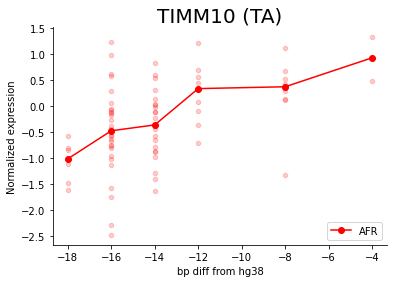

In [7]:
fig, ax = plt.subplots()
plot_eTR("chr11_57528484-ENSG00000134809.4",ax,"TA","TIMM10",reg_file_dir)

In [77]:
# see top hits
reg_results.sort_values(by='p_values')

,str-gene,str_end,motif,gene_name,sample_n,GT_n,p_values,slope,error,shuffled_p,shuffled_slope,shuffled_error,-log10_p_values
616,chr21_43776445-ENSG00000160213.5,43776481,GCGGG,CSTB,89,3,1.022722e-08,0.772511,0.100999,0.764956,-0.055010,0.182433,7.990243
611,chr21_43776443-ENSG00000160213.5,43776478,GCGCGGGGCGGG,CSTB,89,3,1.022722e-08,0.772511,0.100999,0.848410,-0.034271,0.177842,7.990243
136,chr21_42904492-ENSG00000160199.8,42904510,T,PKNOX1,88,6,1.873399e-04,0.548134,0.129315,0.288896,0.193565,0.179387,3.727370
84,chr21_42871991-ENSG00000160193.7,42872001,T,WDR4,89,3,5.329217e-04,-0.360057,0.093524,0.239720,0.175881,0.146814,3.273337
140,chr21_42907449-ENSG00000160193.7,42907469,T,WDR4,87,5,1.309374e-03,-0.313768,0.088504,0.783635,0.045854,0.165502,2.882936
...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,chr21_42999475-ENSG00000160200.12,42999498,TTTTC,CBS,89,3,9.921196e-01,-0.001252,0.125738,0.351278,0.194613,0.205739,0.003436
538,chr21_43724682-ENSG00000160209.12,43724695,A,PDXK,89,3,9.965180e-01,-0.000632,0.143616,0.176802,0.205109,0.148506,0.001515
563,chr21_43736630-ENSG00000160209.12,43736649,T,PDXK,85,4,9.970224e-01,0.000583,0.154788,0.528762,0.107362,0.168322,0.001295
37,chr21_42811264-ENSG00000160194.11,42811290,T,NDUFV3,87,5,9.981653e-01,0.000410,0.176933,0.437616,0.156050,0.198355,0.000798


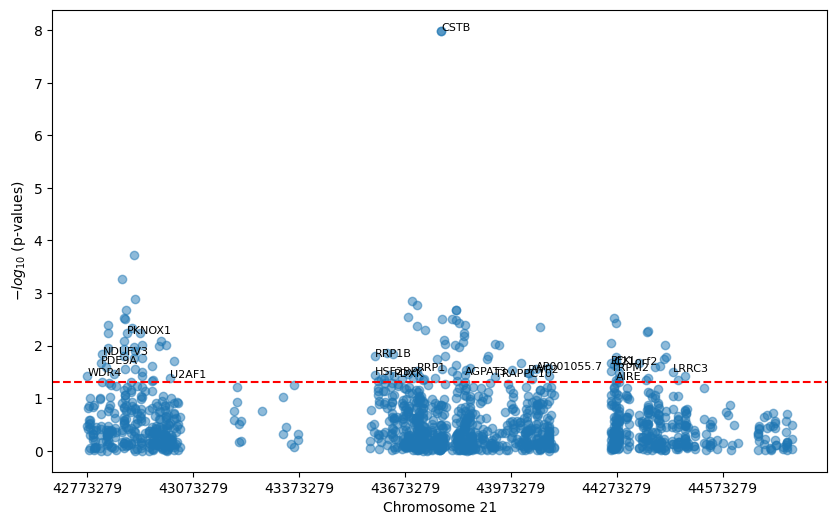

In [117]:
threshold = 0.05

reg_results['str_end'] = reg_results['str_end'].astype(int)
reg_results['-log10_p_values'] = -np.log10(reg_results['p_values'])

plt.figure(figsize=(10, 6))
plt.scatter(reg_results['str_end'], reg_results['-log10_p_values'], alpha=0.5)

unique_names = set()

for index, row in reg_results.iterrows():
    if row['p_values'] < threshold:
        if (row['gene_name']) not in unique_names:
            unique_names.add((row['gene_name']))
            plt.text(row['str_end'], row['-log10_p_values'], f"{row['gene_name']}", fontsize=8, ha='left')

# dashed line
plt.axhline(-np.log10(0.05), color='red', linestyle='--')

plt.xlabel('Chromosome 21')
plt.ylabel("$-log_{10}$ (p-values)")

x_ticks = np.arange(reg_results['str_end'].min(), reg_results['str_end'].max() + 1, 300000)
plt.xticks(x_ticks)
plt.ticklabel_format(style='plain')

plt.show()


In [123]:
reg_results.query("p_values <= 0.05").sort_values(by='p_values')['gene_name'].unique()

array(['CSTB', 'PKNOX1', 'WDR4', 'HSF2BP', 'PDXK', 'C21orf2', 'RRP1',
       'AP001055.7', 'TRPM2', 'NDUFV3', 'PFKL', 'AGPAT3', 'RRP1B',
       'PDE9A', 'AIRE', 'PWP2', 'LRRC3', 'TRAPPC10', 'U2AF1'],
      dtype=object)